In [19]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [22]:
# Load and preprocess
df = pd.read_csv('/content/AirPassengers.csv')
df.columns = ['Month', 'Passengers']
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [23]:
# Add month features (sin and cos encoding for seasonality)
df['Month_Num'] = df.index.month
df['Month_sin'] = np.sin(2 * np.pi * df['Month_Num'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month_Num'] / 12)

In [24]:
# Scale only Passengers column
scaler = MinMaxScaler()
df['Passengers_scaled'] = scaler.fit_transform(df[['Passengers']])

In [25]:
# Use scaled passengers + seasonality features
features = df[['Passengers_scaled', 'Month_sin', 'Month_cos']].values

In [26]:
# Create sequences
sequence_length = 12
X = []
y = []

for i in range(sequence_length, len(features)):
    X.append(features[i - sequence_length:i])     # 12 time steps
    y.append(features[i][0])                      # predict passenger only

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

In [28]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=3, hidden_size=100, num_layers=2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last time step output
        return out

model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [29]:
# Train the model
num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    output = model(X)
    loss = criterion(output, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 25 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')


Epoch [25/300], Loss: 0.033859
Epoch [50/300], Loss: 0.005339
Epoch [75/300], Loss: 0.001972
Epoch [100/300], Loss: 0.001448
Epoch [125/300], Loss: 0.000988
Epoch [150/300], Loss: 0.000767
Epoch [175/300], Loss: 0.000726
Epoch [200/300], Loss: 0.000707
Epoch [225/300], Loss: 0.000692
Epoch [250/300], Loss: 0.000679
Epoch [275/300], Loss: 0.000670
Epoch [300/300], Loss: 0.000662


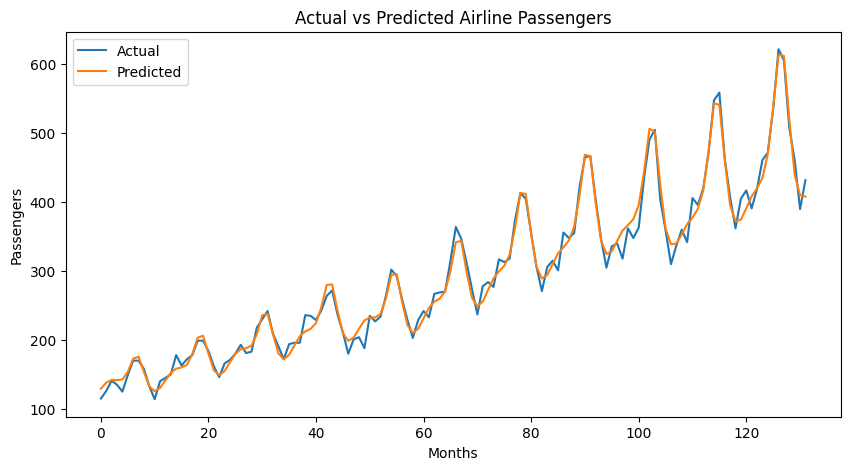

In [30]:
# Evaluate and plot predictions
model.eval()
with torch.no_grad():
    predictions = model(X).detach().numpy()

predicted = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(y.numpy())

plt.figure(figsize=(10,5))
plt.plot(actual, label='Actual')
plt.plot(predicted, label='Predicted')
plt.legend()
plt.title("Actual vs Predicted Airline Passengers")
plt.xlabel("Months")
plt.ylabel("Passengers")
plt.show()

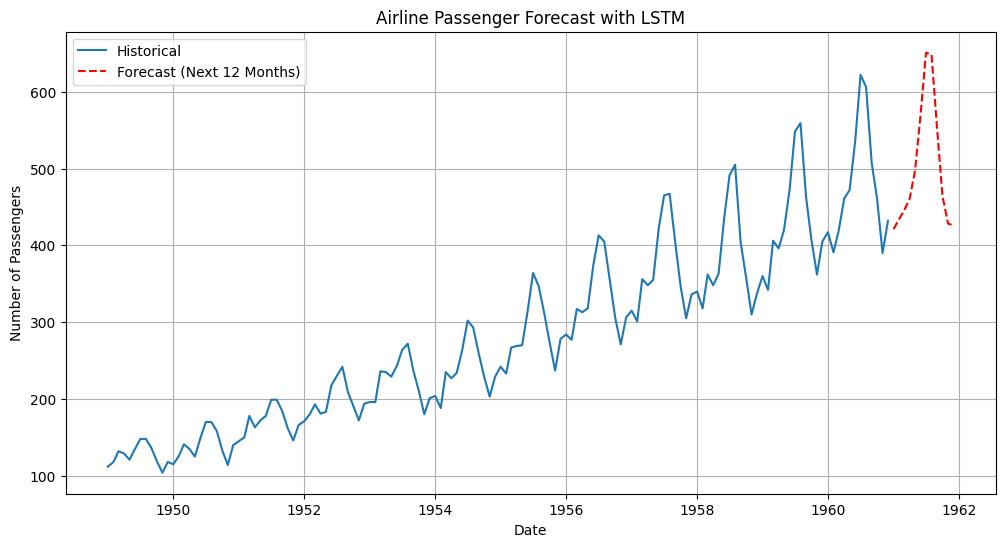

In [31]:
# Forecast next 12 months
future_predictions = []

# Start from last known input sequence
last_seq = features[-sequence_length:].copy()

model.eval()
with torch.no_grad():
    for i in range(12):
        input_seq = torch.tensor(last_seq, dtype=torch.float32).unsqueeze(0)  # shape (1, 12, 3)
        pred = model(input_seq)
        future_val = pred.item()
        future_predictions.append(future_val)

        # Create new row with forecast + correct sin/cos for next month
        last_month = df.index[-1] + pd.DateOffset(months=i+1)
        month_num = last_month.month
        sin_val = np.sin(2 * np.pi * month_num / 12)
        cos_val = np.cos(2 * np.pi * month_num / 12)

        # Update sequence with new forecast and time features
        next_input = np.array([[future_val, sin_val, cos_val]])
        last_seq = np.vstack((last_seq[1:], next_input))  # shift left

# Inverse transform predicted passenger values
future_predictions_real = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Prepare dates
future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
forecast_df = pd.DataFrame({'Month': future_dates, 'Predicted_Passengers': future_predictions_real.flatten()})
forecast_df.set_index('Month', inplace=True)

# Plot full series
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Passengers'], label='Historical')
plt.plot(forecast_df.index, forecast_df['Predicted_Passengers'], label='Forecast (Next 12 Months)', linestyle='--', color='red')
plt.title("Airline Passenger Forecast with LSTM")
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.legend()
plt.grid(True)
plt.show()